<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/Kmeans_Bafv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [100]:
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
random.seed(42)
import os
import math
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from google.colab import files
import re

import warnings
warnings.filterwarnings('ignore')

# UTILS

Set of Features (aka data columns)

In [102]:
#Master dataset
#FEATURES
META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['session_length_in_minutes', 'email_is_free',
       'proposed_credit_limit','name_email_similarity',
      'zip_count_4w', 'date_of_birth_distinct_emails_4w',
      'phone_mobile_valid', 'has_other_cards', 'foreign_request']
SEN = ['customer_age', 'income'] #protected attributes in BAF paper also employment_status
DUMMY = ['source_INTERNET', 'source_TELEAPP', 'device_os_other', 'device_os_macintosh','device_os_linux','device_os_windows', 'device_os_x11']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['session_length_in_minutes_scaled',
              'email_is_free_scaled',
              'proposed_credit_limit_scaled',
              'name_email_similarity_scaled',
              'zip_count_4w_scaled',
              'date_of_birth_distinct_emails_4w_scaled','has_other_cards_scaled', 'foreign_request_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled']
DUMMY_scaled = ['source_INTERNET_scaled', 'source_TELEAPP_scaled', 'device_os_other_scaled', 'device_os_macintosh_scaled', 'device_os_linux_scaled', 'device_os_windows_scaled', 'device_os_x11_scaled']


#SHAP FEATURES
SHAP_REG = [
    'Shap_session_length_in_minutes', 'Shap_email_is_free',
    'Shap_proposed_credit_limit', 'Shap_name_email_similarity',
    'Shap_zip_count_4w', 'Shap_date_of_birth_distinct_emails_4w',
    'Shap_phone_mobile_valid', 'Shap_has_other_cards', 'Shap_foreign_request'
]

SHAP_SEN = ['Shap_customer_age', 'Shap_income']

SHAP_DUMMY = [
    'Shap_source_INTERNET', 'Shap_source_TELEAPP',
    'Shap_device_os_other', 'Shap_device_os_macintosh',
    'Shap_device_os_linux', 'Shap_device_os_windows', 'Shap_device_os_x11'
]

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_session_length_in_minutes_scaled',
    'Shap_email_is_free_scaled', 'Shap_proposed_credit_limit_scaled',
    'Shap_name_email_similarity_scaled', 'Shap_zip_count_4w_scaled',
    'Shap_date_of_birth_distinct_emails_4w_scaled',
    'Shap_phone_mobile_valid_scaled', 'Shap_has_other_cards_scaled',
    'Shap_foreign_request_scaled'
]

SHAP_SEN_scaled = ['Shap_customer_age_scaled', 'Shap_income_scaled']

SHAP_DUMMY_scaled = [
    'Shap_source_INTERNET_scaled', 'Shap_source_TELEAPP_scaled',
    'Shap_device_os_other_scaled', 'Shap_device_os_macintosh_scaled',
    'Shap_device_os_linux_scaled', 'Shap_device_os_windows_scaled',
    'Shap_device_os_x11_scaled'
]

'''removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', '''

"removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',\n'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',\n'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', "

# Utils for Data prep

In [103]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

'''undo Dummy for DUMMY_source or DUMMY_device'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)


# Utils for Clustering

In [104]:
# Calculate average (unscaled) Error rate by counting the amount of max values (1) and dividing them by the total nr of rows
# Does not work on scaled (binary) error features
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate


def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[filter_tf]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)


# Utils for Results

make recap

In [147]:
'''def make_recap(data_result, feature_set):
  #replaced all count / categorical calculations (poisson) with t-test and mean calculation for continuous. except for error
    # Make recap of cluster info with error rates

    res = data_result[['clusters', 'errors']]

    # Cluster size
    temp = data_result[['clusters']].copy()
    temp['count'] = 1
    recap = temp.groupby(['clusters'], as_index=False).sum()

    # Number of errors and error rate calculation
    recap['n_error'] = res.groupby(['clusters']).sum().astype(int)
    recap['error_rate'] = res.groupby(['clusters']).mean()

    # Quality metrics preparation
    diff_vs_rest, diff_p = [], []
    age_mean, age_diff, age_p = [], [], []
    income_mean, income_diff, income_p = [], [], []
    silhouette = []

    # Calculate silhouette scores if more than one cluster exists
    clusters = data_result['clusters']
    if len(recap['clusters'].unique()) > 1:
        silhouette_val = silhouette_samples(data_result[feature_set], clusters)
    if recap.empty:
      print("Recap DataFrame is empty! Skipping this iteration.")
      return

    for c in recap['clusters']:
        print(f"Processing cluster: {c}")

        # In-cluster data
        c_data = data_result.loc[data_result['clusters'] == c]
        c_count = recap['count'][c]
        print(f"Data points in cluster {c}: {len(c_data)}")

        # Out-of-cluster data
        rest_data = data_result.loc[data_result['clusters'] != c]
        print(f"Data points outside cluster {c}: {len(rest_data)}")
        if len(rest_data) == 0:
            diff_vs_rest.extend([np.nan])
            #age_prop.extend([np.nan])
            age_mean.extend([np.nan])
            #income_prop.extend([np.nan])
            income_mean.extend([np.nan])
            silhouette.append(np.nan)
            continue

        # Add silhouette score
        silhouette.append(silhouette_val[clusters == c].mean())

        matching_silhouettes = silhouette_val[clusters == c]
        if len(matching_silhouettes) == 0:
          print(f"No matching silhouette values found for cluster {c}")
          silhouette.append(np.nan)
        else:
          silhouette.append(matching_silhouettes.mean())
          print(f"Silhouette mean for cluster {c}: {matching_silhouettes.mean()}")

        rest_recap = recap.loc[recap['clusters'] != c]
        rest_count = rest_recap['count'].sum()

        # Error rate difference
        rest_n_error = rest_recap['n_error'].sum()
        rest_rate = rest_n_error / rest_count
        diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

        if rest_count == 0:
          print(f"No rest count data for cluster {c}")
          diff_vs_rest.append(np.nan)
        else:
          rest_rate = rest_n_error / rest_count
          print(f"Cluster {c} rest error rate: {rest_rate}")
          diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

        # Deal with splits with 0 error (by using either number of errors (FN or FP), or number of correct classifications (TP or TN))
        #if any(x < 1 for x in [recap['n_error'][c], recap['count'][c], rest_n_error, rest_count]):
            #res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c],
                                           #rest_count - rest_n_error, rest_count)

        # Deal with splits with 0 error OR values less than 1
        #if recap['n_error'][c] == 0 or rest_n_error == 0 or any(x < 1 for x in [recap['count'][c], rest_count]):
            # Use number of correct classifications (TP or TN) instead
            r#es = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c],
                                           #rest_count - rest_n_error, rest_count)
        #else:
            #res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
        #diff_p.append(round(res.pvalue, 3))

        if any(x < 1 for x in [recap['n_error'][c], recap['count'][c], rest_n_error, rest_count]):
          print(f"Using alternate Poisson test for cluster {c} due to low counts.")
          res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c],
                                   rest_count - rest_n_error, rest_count)
        else:
          res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
          print(f"Poisson test p-value for cluster {c}: {res.pvalue}")
          diff_p.append(round(res.pvalue, 3))

        #### Sensitive features (age, income)
        # Age feature (customer_age)

        t_stat, p_val = stats.ttest_ind(c_data['customer_age'], rest_data['customer_age'], equal_var = False)

        #old for poisson
        #rest_n_age = rest_data['customer_age'].sum()
        #rest_prop_age = rest_n_age / rest_count
        #c_n_age = c_data['customer_age'].sum()
        #c_prop_age = c_n_age / c_count


        rest_mean_age = rest_data['customer_age'].mean()
        #rest_prop_age = rest_mean_age / rest_count
        c_mean_age = c_data['customer_age'].mean()
        #c_prop_age = c_mean_age / c_count

        #if any(x < 1 for x in [c_mean_age, c_count, rest_mean_age, rest_count]):
            #res = stats.poisson_means_test(c_count - c_mean_age, c_count, rest_count - rest_mean_age, rest_count)
        #else:
            r#es = stats.poisson_means_test(c_mean_age, c_count, rest_mean_age, rest_count)
        #age_p.append(round(res.pvalue, 3))

        #if c_data['customer_age'].size > 1 and rest_data['customer_age'].size > 1:
          #t_stat, p_val = ttest_ind(c_data['customer_age'], rest_data['customer_age'], equal_var = False)
          #age_p.append(round(p_val, 3))
        #else:
            #age_p.append(np.nan)

        #age_prop.append(c_prop_age)
        age_mean.append(c_mean_age)
        #age_diff.append(c_prop_age - rest_prop_age)
        age_diff.append(c_mean_age - rest_mean_age)


        # Income feature (income)

        t_stat, p_val = stats.ttest_ind(c_data['income'], rest_data['income'], equal_var = False)

        #old for poisson
        #rest_n_income = rest_data['income'].sum()
        #rest_prop_income = rest_n_income / rest_count
        #c_n_income = c_data['income'].sum()
        #c_prop_income = c_n_income / c_count


        rest_mean_income = rest_data['income'].mean()
        #rest_prop_income = rest_mean_income / rest_count
        c_mean_income = c_data['income'].mean()
        #c_prop_income = c_mean_income / c_count

        #print('c_n_income:', c_mean_income)
        print('c_mean_income:', c_mean_income)
        #print('c_count:', c_count)
        #print('rest_n_income:', rest_mean_income)
        print('rest_mean_income:', rest_mean_income)
        #print('rest_count:', rest_count)

        if c_data['income'].size > 1 and rest_data['income'].size > 1:
          t_stat, p_val = ttest_ind(c_data['income'], rest_data['income'], equal_var = False)
          income_p.append(round(p_val, 3))
        else:
          income_p.append(np.nan)

        #income_prop.append(c_prop_income)
        #income_diff.append(c_prop_income - rest_prop_income)
        income_mean.append(c_mean_income)
        income_diff.append(c_mean_income - rest_mean_income)

        #if any(x < 1 for x in [c_mean_income, c_count, rest_mean_income, rest_count]):
         #   res = stats.poisson_means_test(c_count - c_mean_income, c_count, rest_count - rest_mean_income, rest_count)
          #  #res = stats.ttest_ind()
        #else:
         #   res = stats.poisson_means_test(c_mean_income, c_count, rest_mean_income, rest_count)
        #income_p.append(round(res.pvalue, 3))

    print(f"Length of diff_vs_rest: {len(diff_vs_rest)}")
    print(f"Length of age_mean: {len(age_mean)}")
    print(f"Length of income_mean: {len(income_mean)}")
    print(f"Length of silhouette: {len(silhouette)}")


    # Populate recap DataFrame with results
    recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
    recap['diff_p'] = diff_p
    #recap['age_prop'] = np.around(age_prop, 3)
    recap['age_mean'] = np.around(age_mean, 3)
    recap['age_diff'] = np.around(age_diff, 3)
    recap['age_p'] = np.nan #age_p
    #recap['income_prop'] = np.around(income_prop, 3)
    recap['income_mean'] = np.around(income_mean, 3)
    recap['income_diff'] = np.around(income_diff, 3)
    recap['income_p'] = np.nan #income_p
    recap['silhouette'] = silhouette
    recap['error_rate'] = np.around(recap['error_rate'], 3)

    # Rename columns for clarity
    recap.rename(columns={'clusters': 'c'}, inplace=True)

    return recap '''

In [148]:
def make_recap(data_result, feature_set):
    # Recap DataFrame initialization
    res = data_result[['clusters', 'errors']]
    temp = data_result[['clusters']].copy()
    temp['count'] = 1
    recap = temp.groupby(['clusters'], as_index=False).sum()

    recap['n_error'] = res.groupby(['clusters']).sum().astype(int)
    recap['error_rate'] = res.groupby(['clusters']).mean()

    # Initialize metrics
    diff_vs_rest, diff_p = [], []
    age_mean, age_diff, age_p = [], [], []
    income_mean, income_diff, income_p = [], [], []
    silhouette = []

    # Calculate silhouette scores if multiple clusters exist
    clusters = data_result['clusters']
    silhouette_val = None
    if len(recap['clusters'].unique()) > 1:
        silhouette_val = silhouette_samples(data_result[feature_set], clusters)

    for c in recap['clusters']:
        print(f"Processing cluster: {c}")

        # In-cluster and rest-of-data
        c_data = data_result.loc[data_result['clusters'] == c]
        print(f"Data points in cluster {c}: {len(c_data)}")

        rest_data = data_result.loc[data_result['clusters'] != c]
        print(f"Data points outside cluster {c}: {len(rest_data)}")

        # Silhouette scores
        if silhouette_val is not None:
            cluster_silhouette = silhouette_val[clusters == c]
            if len(cluster_silhouette) == 0:
                print(f"No matching silhouette values found for cluster {c}")
                silhouette.append(np.nan)
            else:
                print(f"Silhouette mean for cluster {c}: {cluster_silhouette.mean()}")
                silhouette.append(cluster_silhouette.mean())
        else:
            silhouette.append(np.nan)

        # Error rate difference
        rest_recap = recap.loc[recap['clusters'] != c]
        rest_count = rest_recap['count'].sum()
        rest_n_error = rest_recap['n_error'].sum()
        rest_rate = rest_n_error / rest_count if rest_count > 0 else np.nan
        if rest_count == 0:
            print(f"No rest count data for cluster {c}")
            diff_vs_rest.append(np.nan)
        else:
            print(f"Cluster {c} rest error rate: {rest_rate}")
            diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

        # Poisson test
        if any(x < 1 for x in [recap['n_error'][c], recap['count'][c], rest_n_error, rest_count]):
            print(f"Using alternate Poisson test for cluster {c} due to low counts.")
            diff_p.append(np.nan)  # Skip Poisson for low counts
        else:
            res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
            print(f"Poisson test p-value for cluster {c}: {res.pvalue}")
            diff_p.append(round(res.pvalue, 3))

        # Age feature
        if 'customer_age' in c_data.columns and c_data['customer_age'].size > 1 and rest_data['customer_age'].size > 1:
            t_stat, p_val = stats.ttest_ind(c_data['customer_age'], rest_data['customer_age'], equal_var=False)
            print(f"Age t-test for cluster {c}: p-value = {p_val}")
            age_p.append(round(p_val, 3))
            c_mean_age = c_data['customer_age'].mean()
            rest_mean_age = rest_data['customer_age'].mean()
            age_mean.append(c_mean_age)
            age_diff.append(c_mean_age - rest_mean_age)
            print(f"Cluster {c} mean age: {c_mean_age}, Rest mean age: {rest_mean_age}")
        else:
            print(f"Insufficient age data for cluster {c}")
            age_p.append(np.nan)
            age_mean.append(np.nan)
            age_diff.append(np.nan)

        # Income feature
        if c_data['income'].size > 1 and rest_data['income'].size > 1:
            t_stat, p_val = stats.ttest_ind(c_data['income'], rest_data['income'], equal_var=False)
            print(f"Income t-test for cluster {c}: p-value = {p_val}")
            income_p.append(round(p_val, 3))
            c_mean_income = c_data['income'].mean()
            rest_mean_income = rest_data['income'].mean()
            income_mean.append(c_mean_income)
            income_diff.append(c_mean_income - rest_mean_income)
            print(f"Cluster {c} mean income: {c_mean_income}, Rest mean income: {rest_mean_income}")
        else:
            print(f"Insufficient income data for cluster {c}")
            income_p.append(np.nan)
            income_mean.append(np.nan)
            income_diff.append(np.nan)

    print(f"Length of diff_vs_rest: {len(diff_vs_rest)}")
    print(f"Length of age_mean: {len(age_mean)}")
    print(f"Length of income_mean: {len(income_mean)}")
    print(f"Length of silhouette: {len(silhouette)}")

    # Final DataFrame population
    recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
    recap['diff_p'] = diff_p
    recap['age_mean'] = np.around(age_mean, 3)
    recap['age_diff'] = np.around(age_diff, 3)
    recap['age_p'] = age_p
    recap['income_mean'] = np.around(income_mean, 3)
    recap['income_diff'] = np.around(income_diff, 3)
    recap['income_p'] = income_p
    recap['silhouette'] = np.around(silhouette, 3)
    recap['error_rate'] = np.around(recap['error_rate'], 3)

    # Rename columns for clarity
    recap.rename(columns={'clusters': 'c'}, inplace=True)

    return recap


## Chi-Square or ANOVA Tests

In [149]:
from scipy.stats import chi2_contingency, f_oneway
import pandas as pd
import numpy as np

def make_combined_tests(results):
    combined_res = {
        'cond_descr': [],
        'cond_name': [],
        'chi_error_p': [],
        'anova_age_p': [],
        'anova_income_p': []
    }

    for i in range(len(results['cond_name'])):
        # Add condition descriptions
        combined_res['cond_descr'].append(results['cond_descr'][i])
        combined_res['cond_name'].append(results['cond_name'][i])

        data = results['cond_res'][i]
        recap = results['cond_recap'][i]

        # If only one cluster, skip statistical tests
        if len(recap['diff_p']) == 1:
            combined_res['chi_error_p'].append(np.nan)
            combined_res['anova_age_p'].append(np.nan)
            combined_res['anova_income_p'].append(np.nan)
            continue

        # 1. Chi-Square Test for Errors
        try:
            test_data = recap[['count', 'n_error']].copy(deep=True)
            test_data['count'] = test_data['count'] - test_data['n_error']
            test_data = test_data.rename(columns={"count": "n_correct"})
            test_data = test_data.transpose()
            chi_stat, chi_p, _, _ = chi2_contingency(test_data)
            combined_res['chi_error_p'].append(round(chi_p, 6))
        except Exception as e:
            combined_res['chi_error_p'].append(np.nan)

        # 2. ANOVA for Age
        try:
            groups_age = [data['customer_age'][data['clusters'] == c] for c in recap['c']]
            fvalue_age, pvalue_age = f_oneway(*groups_age)
            combined_res['anova_age_p'].append(round(pvalue_age, 6))
        except Exception as e:
            combined_res['anova_age_p'].append(np.nan)

        # 3. ANOVA for Income
        try:
            groups_income = [data['income'][data['clusters'] == c] for c in recap['c']]
            fvalue_income, pvalue_income = f_oneway(*groups_income)
            combined_res['anova_income_p'].append(round(pvalue_income, 6))
        except Exception as e:
            combined_res['anova_income_p'].append(np.nan)

    return pd.DataFrame(combined_res)

In [150]:
'''def make_chi_tests(results):
  chi_res = {'cond_descr': [],
            'cond_name': [],
            'error': [],
            'age': [],
            'income': []}

  for i in range(0, len(results['cond_name'])):
    chi_res['cond_descr'].append(results['cond_descr'][i])
    chi_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    if(len(recap['diff_p']) == 1):
      chi_res['error'].append(np.nan)
      chi_res['age'].append(np.nan)
      chi_res['income'].append(np.nan)
      continue

    # Test error differences
    test_data = recap[['count', 'n_error']].copy(deep=True)

    test_data['count'] = test_data['count'] - test_data['n_error']
    test_data = test_data.rename(columns={"count": "n_correct"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['error'].append(round(test_res.pvalue, 6))

    #print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test income differences
    test_data = recap[['count', 'income_prop']].copy(deep=True)

    test_data['income_prop'] = round(test_data['count'] * test_data['income_prop'])
    test_data = test_data.rename(columns={"income_prop": "income_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['income_n']
    test_data = test_data.rename(columns={"count": "income_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['income'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test age differences
    test_data = recap[['count', 'age_prop']].copy(deep=True)

    test_data['age_prop'] = round(test_data['count'] * test_data['age_prop'])
    test_data = test_data.rename(columns={"age_prop": "age_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['age_n']
    test_data = test_data.rename(columns={"count": "age_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['age'].append(round(test_res.pvalue, 6))

  return(pd.DataFrame(chi_res))
'''

'def make_chi_tests(results):\n  chi_res = {\'cond_descr\': [],\n            \'cond_name\': [],\n            \'error\': [],\n            \'age\': [],\n            \'income\': []}\n\n  for i in range(0, len(results[\'cond_name\'])):\n    chi_res[\'cond_descr\'].append(results[\'cond_descr\'][i])\n    chi_res[\'cond_name\'].append(results[\'cond_name\'][i])\n    data = results[\'cond_res\'][i]\n    recap = results[\'cond_recap\'][i]\n\n    if(len(recap[\'diff_p\']) == 1):\n      chi_res[\'error\'].append(np.nan)\n      chi_res[\'age\'].append(np.nan)\n      chi_res[\'income\'].append(np.nan)\n      continue\n\n    # Test error differences\n    test_data = recap[[\'count\', \'n_error\']].copy(deep=True)\n\n    test_data[\'count\'] = test_data[\'count\'] - test_data[\'n_error\']\n    test_data = test_data.rename(columns={"count": "n_correct"})\n\n    test_data = test_data.transpose()\n    test_res = chi2_contingency(test_data)\n    chi_res[\'error\'].append(round(test_res.pvalue, 6))\n\n  

## Anova Tests

In [151]:
'''from scipy.stats import f_oneway

def make_anova_tests(results):
  anova_res = {'cond_descr': [],
               'cond_name': [],
               'error': [],
               'age': [],
               'income': []}

  for i in range(0, len(results['cond_name'])):
    anova_res['cond_descr'].append(results['cond_descr'][i])
    anova_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    if len(recap['diff_p']) == 1:  # Check if only one cluster
      anova_res['error'].append(np.nan)
      anova_res['age'].append(np.nan)
      anova_res['income'].append(np.nan)
      continue

    # Test error differences (ANOVA)
    groups = [data['errors'][data['clusters'] == c] for c in recap['c']]
    fvalue, pvalue = f_oneway(*groups)  # Perform ANOVA
    anova_res['error'].append(round(pvalue, 6))

    # Test age differences (ANOVA)
    groups = [data['customer_age'][data['clusters'] == c] for c in recap['c']]
    fvalue, pvalue = f_oneway(*groups)  # Perform ANOVA
    anova_res['age'].append(round(pvalue, 6))

    # Test income differences (ANOVA)
    groups = [data['income'][data['clusters'] == c] for c in recap['c']]
    fvalue, pvalue = f_oneway(*groups)  # Perform ANOVA
    anova_res['income'].append(round(pvalue, 6))

  return pd.DataFrame(anova_res)'''

"from scipy.stats import f_oneway\n\ndef make_anova_tests(results):\n  anova_res = {'cond_descr': [],\n               'cond_name': [],\n               'error': [],\n               'age': [],\n               'income': []}\n\n  for i in range(0, len(results['cond_name'])):\n    anova_res['cond_descr'].append(results['cond_descr'][i])\n    anova_res['cond_name'].append(results['cond_name'][i])\n    data = results['cond_res'][i]\n    recap = results['cond_recap'][i]\n\n    if len(recap['diff_p']) == 1:  # Check if only one cluster\n      anova_res['error'].append(np.nan)\n      anova_res['age'].append(np.nan)\n      anova_res['income'].append(np.nan)\n      continue\n\n    # Test error differences (ANOVA)\n    groups = [data['errors'][data['clusters'] == c] for c in recap['c']]\n    fvalue, pvalue = f_oneway(*groups)  # Perform ANOVA\n    anova_res['error'].append(round(pvalue, 6))\n\n    # Test age differences (ANOVA)\n    groups = [data['customer_age'][data['clusters'] == c] for c in rec

## All Quality Metrics

In [166]:
def recap_quali_metrics(chi_or_anova_res, results, exp_condition): #previously only chi_res
  all_quali = {'cond_descr': chi_or_anova_res['cond_descr'],
            'cond_name': chi_or_anova_res['cond_name'],
            'error': chi_or_anova_res['chi_error_p'],
            'age': chi_or_anova_res['anova_age_p'],
            'income': chi_or_anova_res['anova_income_p'],
            'silhouette': []}

  for i in range(0, len(chi_or_anova_res['cond_name'])):
    data = results['cond_res'][i]
    feature_set = exp_condition['feature_set'][i]
    clusters = data['clusters']
    recap = results['cond_recap'][i]
    if(len(recap['diff_p']) == 1):
      all_quali['silhouette'].append(np.nan)
      continue
    silhouette_indiv = silhouette_samples(data[feature_set], clusters)
    silhouette_avg = silhouette_indiv.mean()
    all_quali['silhouette'].append(silhouette_avg)

  return(pd.DataFrame(all_quali))

## Utils for VIZ

In [153]:
def tsne_plot_wClusters(data, title, perplexity, learning_rate, n_iter, alpha, size, tsne_columns, fig_prefix):
  # Extract features for t-SNE and drop other_columns
  tsne_features = data[tsne_columns]
  other_columns = [col for col in data.columns if col not in tsne_features]
  other_features = data[other_columns]

  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
  tsne_result = tsne.fit_transform(tsne_features)
  tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

  temp_dataset = tsne_df.join(other_features, how='left')

  # Create scatterplot using seaborn
  scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, s=size,
                                hue="clusters", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  plt.savefig(fig_prefix+re.sub(' +', '', title)+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

# K-Means Clustering

In [154]:
def hbac_kmeans(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop = 0.05,
                min_acceptable_cluster_prop = 0.03,
                min_acceptable_error_diff = 0.01,
                max_iter=300,
                random_state=None):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
      kmeans = KMeans(**clus_model_kwargs, random_state=42).fit(candidate_cluster[columns_to_use])
      candidate_cluster['new_clusters'] = kmeans.labels_

      # KEEP CLUSTER OR NOT
      # ...are cluster size large enough?
      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad split: too small')
        banned_clusters.append(x)
        continue

      # ...is error rate difference large enough?
      e0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      e1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if(abs(e0 - e1) < min_acceptable_error_diff):
        #print('Bad split: same error')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data

# SETUP EXPERIMENTS

### Prepare Data

In [155]:
v2_all = pd.read_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/v2_all.csv')

#split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(v2_all)
TNFP_data = subset_TN_FP(v2_all)

# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()

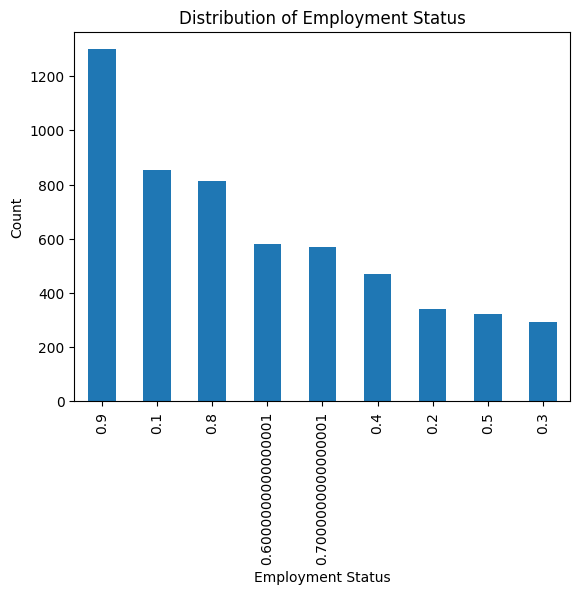

In [156]:
TNFP_data['income'].value_counts().plot(kind='bar')
plt.title('Distribution of Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()

### Set experimental conditions

In [157]:
##### HBAC parameters
min_splittable_cluster_prop = 0.05
min_acceptable_cluster_prop = 0.05
min_acceptable_error_diff = 0.005

##### Make and name the sets of features to experiment with
feature_set_name = []
feature_set_descr = []
feature_set = []

######### BASELINE HBAC
### Does adding SHAP help the clustering?
# Baseline (Mitzal-Radheka)
feature_set_name.append(f'+REG +SEN  -err     -shap')
feature_set_descr.append('Baseline')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled)

# Baseline with Error (Selma)
feature_set_name.append('+REG +SEN +ERR  -shap')
feature_set_descr.append('Baseline with Error')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + ERROR_scaled)

# Adding SHAP values to Baseline (Mirthe;)
feature_set_name.append('+REG +SEN  -err    +SHAP')
feature_set_descr.append('Baseline with SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled)

feature_set_name.append('+REG +SEN +ERR  +SHAP')
feature_set_descr.append('Baseline with SHAP & Error')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + ERROR_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled)

############ SHAP-ONLY HBAC
### Does SHAP alone allow to identify clusters?
# Using only SHAP values
feature_set_name.append('-reg    -sen    -err     +SHAP')
feature_set_descr.append('SHAP only')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP')
feature_set_descr.append('SHAP only with Error')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled + ERROR_scaled)

############ ONLY SENSITIVE FEATURES
### Do sensitive features alone allow to identify clusters?
# Using only Sensitive features
feature_set_name.append('-reg    +SEN  -err     -shap')
feature_set_descr.append('Sensitive features only')
feature_set.append(SEN_scaled)

feature_set_name.append('-reg    +SEN +ERR   -shap')
feature_set_descr.append('Sensitive features with Error')
feature_set.append(SEN_scaled + ERROR_scaled)

### Does adding SHAP help the clustering based on sensitive features?
# Using Sensitive features with SHAP values
feature_set_name.append('-reg    +SEN  -err     +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP')
feature_set.append(SEN_scaled + SHAP_SEN_scaled)

feature_set_name.append('-reg    +SEN +ERR  +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP & Error')
feature_set.append(SEN_scaled + SHAP_SEN_scaled + ERROR_scaled)

# Using only SHAP of Sensitive features
feature_set_name.append('-reg    -sen    -err     +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_SEN_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_SEN_scaled + ERROR_scaled)


############ ONLY REGULAR FEATURES
#conditons without sensitive to check how much it explains the results
feature_set_name.append('+REG -sen    -err     -shap')
feature_set_descr.append('REG Only')
feature_set.append(REG_scaled + DUMMY_scaled)

feature_set_name.append('+REG -sen    +ERR  -shap')
feature_set_descr.append('REG & ERROR')
feature_set.append(REG_scaled + DUMMY_scaled + ERROR_scaled)

feature_set_name.append('+REG -sen    -err     +SHAP_R')
feature_set_descr.append('REG & SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + SHAP_REG_scaled) # ERROR FIXED

feature_set_name.append('+REG -sen    +ERR  +SHAP_R')
feature_set_descr.append('REG, ERROR & SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + ERROR_scaled + SHAP_REG_scaled) # ERROR FIXED

# Using only SHAP of Regular features
feature_set_name.append('-reg    -sen    -err     +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features')
feature_set.append(SHAP_REG_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features + Error')
feature_set.append(SHAP_REG_scaled + ERROR_scaled)

exp_condition = pd.DataFrame({'feature_set_descr': feature_set_descr,
                              'feature_set_name': feature_set_name,
                              'feature_set': feature_set})
exp_condition


,feature_set_descr,feature_set_name,feature_set
0,Baseline,+REG +SEN -err -shap,"[session_length_in_minutes_scaled, email_is_fr..."
1,Baseline with Error,+REG +SEN +ERR -shap,"[session_length_in_minutes_scaled, email_is_fr..."
2,Baseline with SHAP,+REG +SEN -err +SHAP,"[session_length_in_minutes_scaled, email_is_fr..."
3,Baseline with SHAP & Error,+REG +SEN +ERR +SHAP,"[session_length_in_minutes_scaled, email_is_fr..."
4,SHAP only,-reg -sen -err +SHAP,"[Shap_session_length_in_minutes_scaled, Shap_e..."
5,SHAP only with Error,-reg -sen +ERR +SHAP,"[Shap_session_length_in_minutes_scaled, Shap_e..."
6,Sensitive features only,-reg +SEN -err -shap,"[customer_age_scaled, income_scaled]"
7,Sensitive features with Error,-reg +SEN +ERR -shap,"[customer_age_scaled, income_scaled, errors_sc..."
8,Sensitive features with SHAP,-reg +SEN -err +SHAP_S,"[customer_age_scaled, income_scaled, Shap_cust..."
9,Sensitive features with SHAP & Error,-reg +SEN +ERR +SHAP_S,"[customer_age_scaled, income_scaled, Shap_cust..."


#TNFP RESULTS

In [158]:
#TPFN_data.info()

## Execute experiments

In [159]:
results = {'cond_name': [],
           'cond_descr': [],
           'cond_res': [],
           'cond_recap': []}

for i in range(0, len(exp_condition)):

    res = hbac_kmeans(TNFP_data.copy(deep=True),
                      columns_to_use=exp_condition['feature_set'][i],
                      error='errors',
                      min_splittable_cluster_prop=min_splittable_cluster_prop,
                      min_acceptable_cluster_prop=min_acceptable_cluster_prop,
                      min_acceptable_error_diff=min_acceptable_error_diff,
                      max_iter=100,
                      random_state=42)  # Assuming hbac_kmeans accepts random_state

    recap = make_recap(res, exp_condition['feature_set'][i])

    results['cond_name'].append(exp_condition['feature_set_name'][i])
    results['cond_descr'].append(exp_condition['feature_set_descr'][i])
    results['cond_res'].append(res)
    results['cond_recap'].append(recap)


Processing cluster: 0
Data points in cluster 0: 319
Data points outside cluster 0: 5224
Silhouette mean for cluster 0: 0.09299353356764979
Cluster 0 rest error rate: 0.23583460949464014
Poisson test p-value for cluster 0: 0.18599947543023887
Age t-test for cluster 0: p-value = 0.0007078592004481488
Cluster 0 mean age: 38.495297805642636, Rest mean age: 41.38782542113323
Income t-test for cluster 0: p-value = 0.009846296431451112
Cluster 0 mean income: 0.609717868338558, Rest mean income: 0.5670558958652374
Processing cluster: 1
Data points in cluster 1: 1624
Data points outside cluster 1: 3919
Silhouette mean for cluster 1: 0.07530767552075805
Cluster 1 rest error rate: 0.3192140852258229
Poisson test p-value for cluster 1: 0.0
Age t-test for cluster 1: p-value = 1.2661039943600956e-21
Cluster 1 mean age: 38.47290640394089, Rest mean age: 42.36029599387599
Income t-test for cluster 1: p-value = 0.04647655975715326
Cluster 1 mean income: 0.5814655172413794, Rest mean income: 0.564557285

In [ ]:
# Count the number of missing values in each column
#missing_counts = TNFP_data.isnull().sum(axis=0)

# Print the result
#print(missing_counts)

income                             0
name_email_similarity              0
customer_age                       0
zip_count_4w                       0
bank_branch_count_8w               0
                                  ..
Shap_device_os_linux_scaled        0
Shap_device_os_macintosh_scaled    0
Shap_device_os_other_scaled        0
Shap_device_os_windows_scaled      0
Shap_device_os_x11_scaled          0
Length: 89, dtype: int64


### CHI-Square/ ANOVA Tests TNFP data

In [161]:
combined_res = make_combined_tests(results)
combined_res_viz = combined_res.set_index('cond_name').drop('cond_descr', axis=1)
combined_res_viz = round(combined_res_viz, 6)
print(combined_res_viz)

                                  chi_error_p  anova_age_p  anova_income_p
cond_name                                                                 
+REG +SEN  -err     -shap            0.000000          0.0             0.0
+REG +SEN +ERR  -shap                     NaN          NaN             NaN
+REG +SEN  -err    +SHAP             0.000000          0.0             0.0
+REG +SEN +ERR  +SHAP                0.000000          0.0             0.0
-reg    -sen    -err     +SHAP       0.000000          0.0             0.0
-reg    -sen    +ERR  +SHAP          0.000000          0.0             0.0
-reg    +SEN  -err     -shap         0.000000          0.0             0.0
-reg    +SEN +ERR   -shap                 NaN          NaN             NaN
-reg    +SEN  -err     +SHAP_S       0.000000          0.0             0.0
-reg    +SEN +ERR  +SHAP_S           0.000763          0.0             0.0
-reg    -sen    -err     +SHAP_S     0.000000          0.0             0.0
-reg    -sen    +ERR  +SH

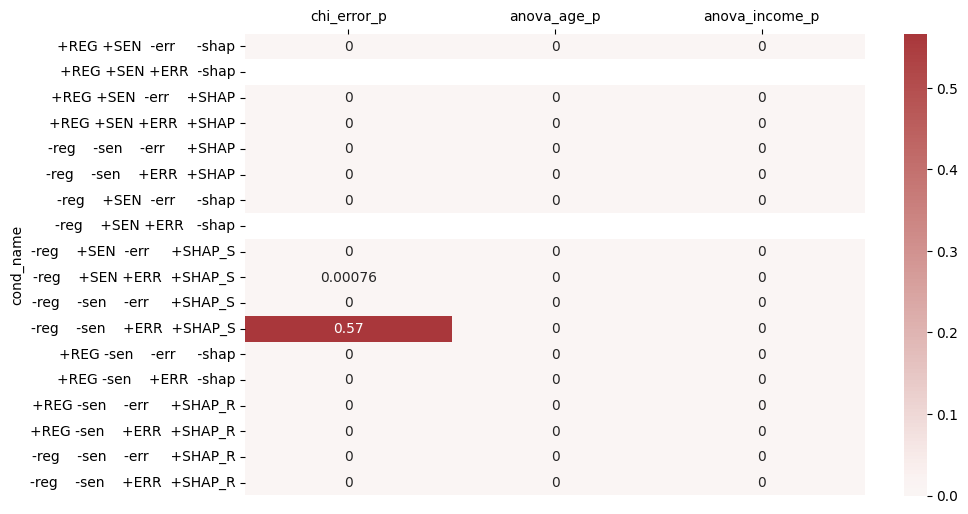

In [162]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(#chi_res_viz,
                 combined_res_viz,annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

### ALL quality metrics TNFP data

In [167]:
all_quali = recap_quali_metrics(#chi_res,
                                combined_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

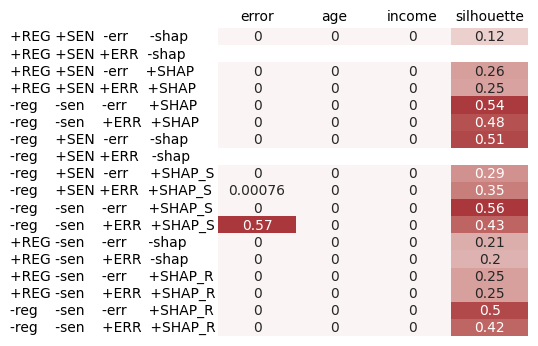

In [168]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TNFP_Kmeans.png', bbox_inches='tight', pad_inches=0)
files.download('TNFP_Kmeans.png')
plt.show()


# Detailed TNFP results

### One-vs-All cluster comparison TNFP data

0


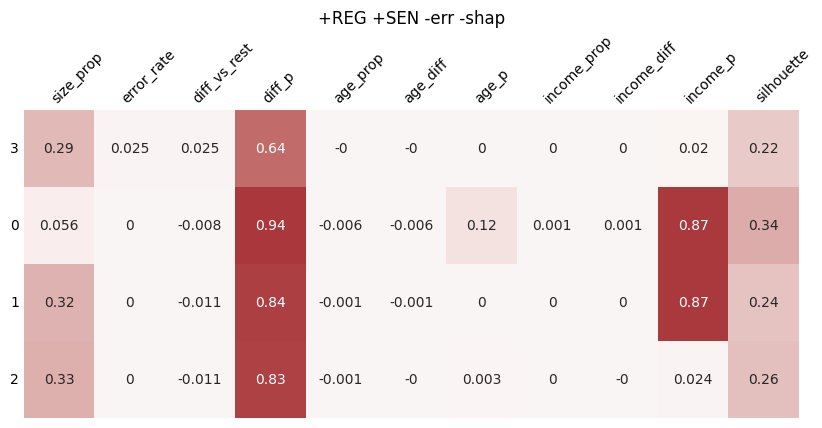

1


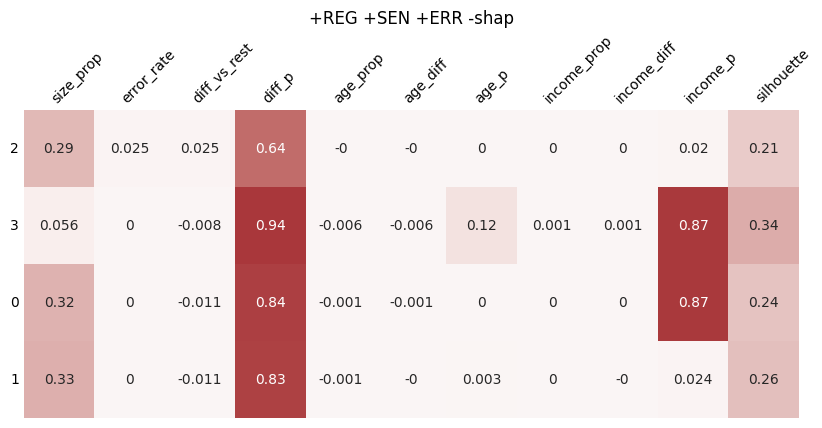

2


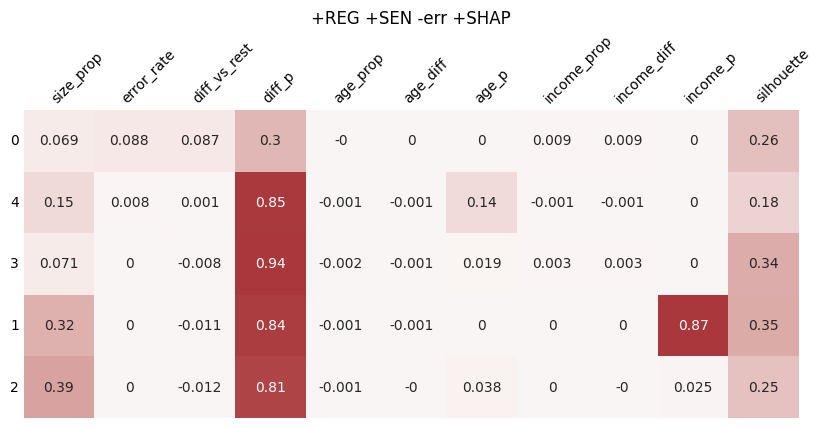

3


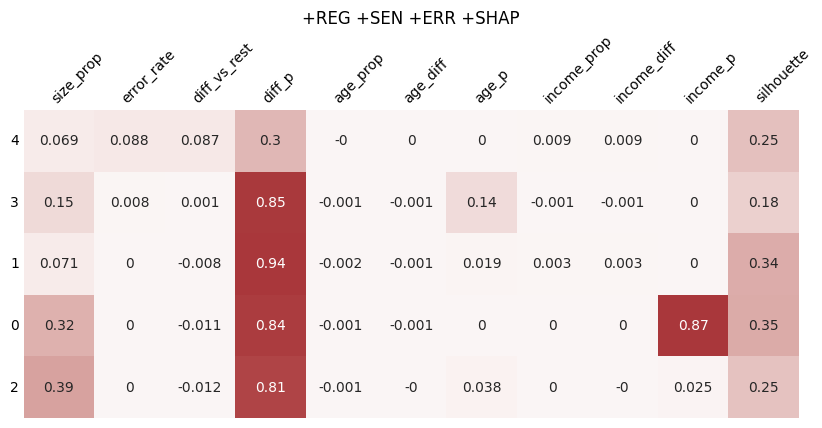

4


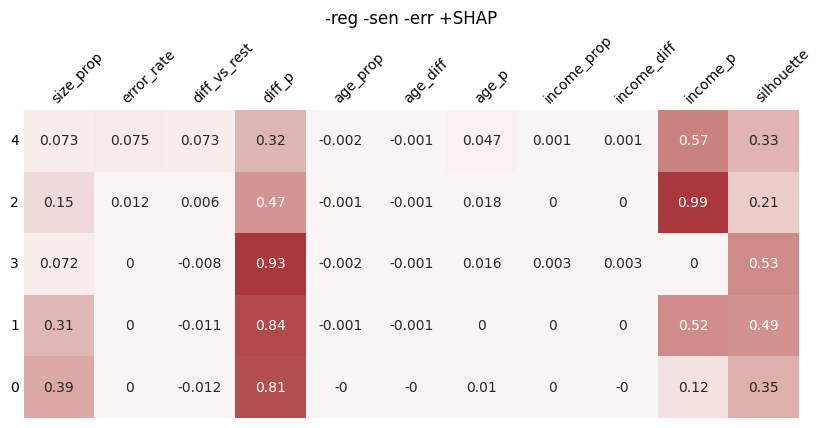

5


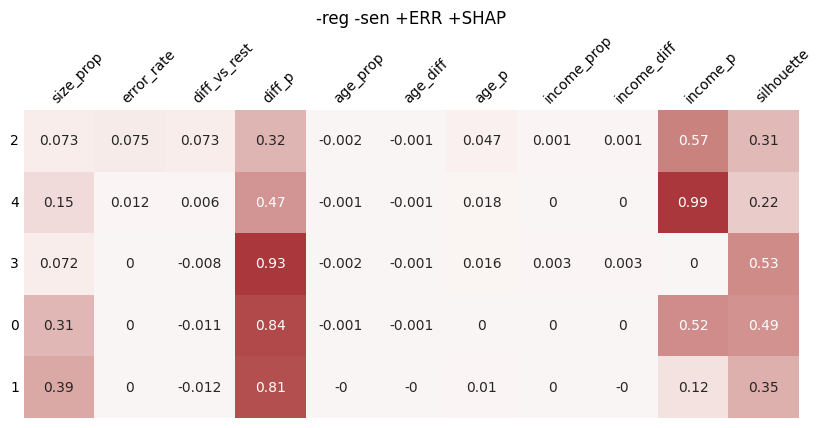

6


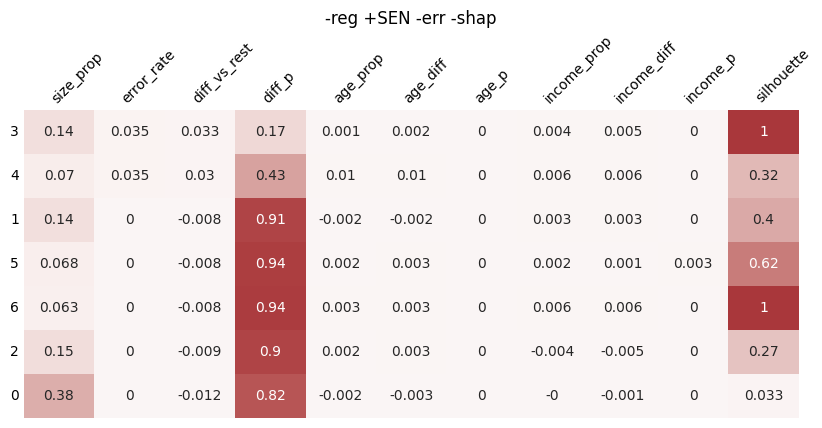

7


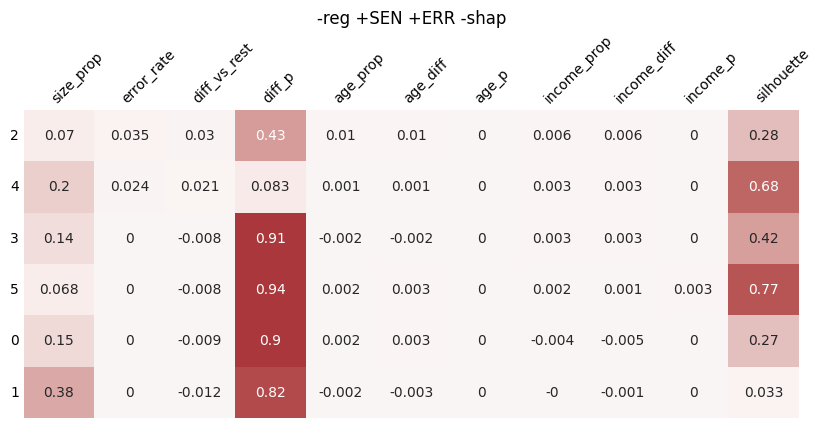

8


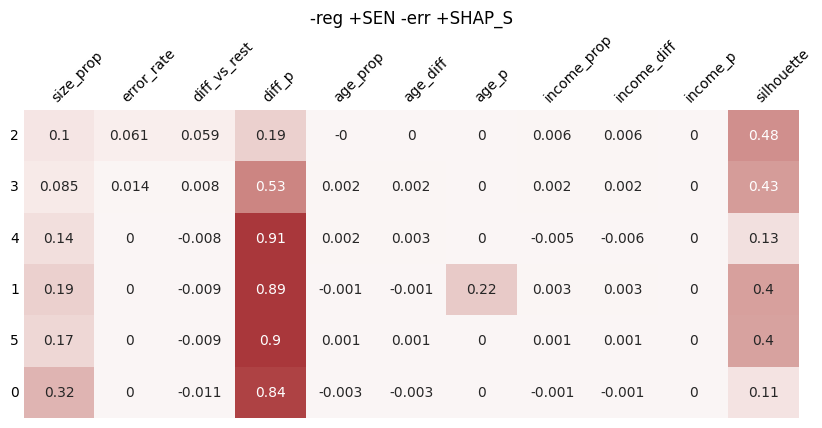

9


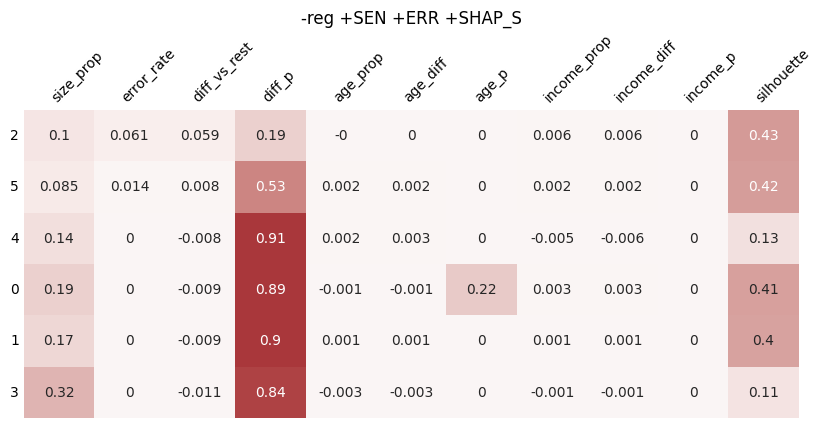

10


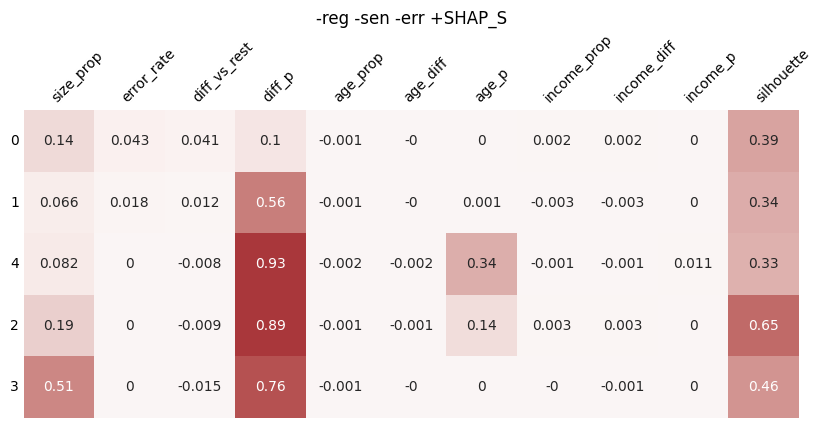

11


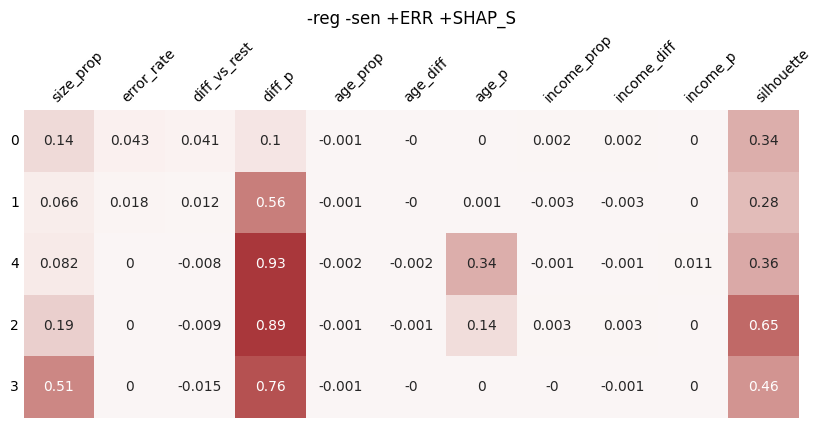

12


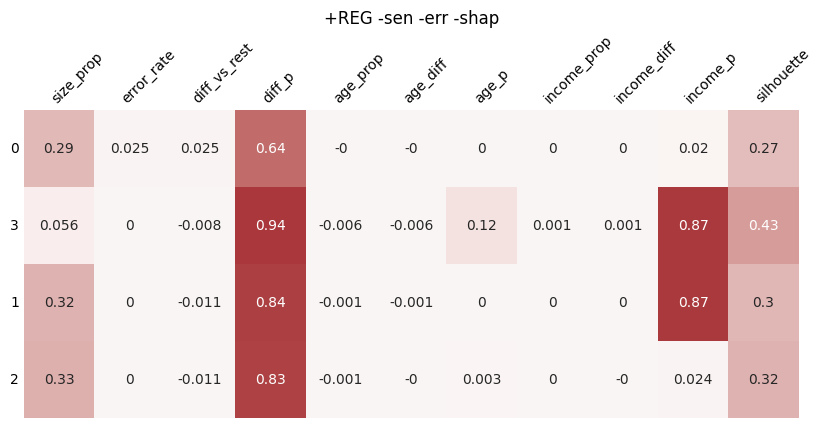

13


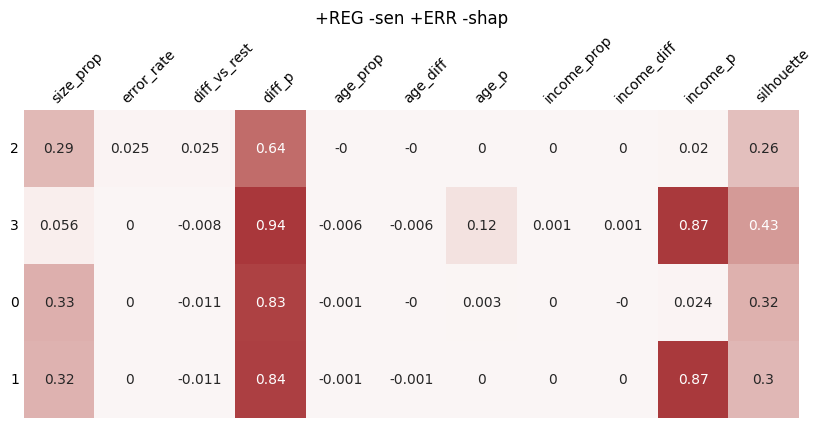

14


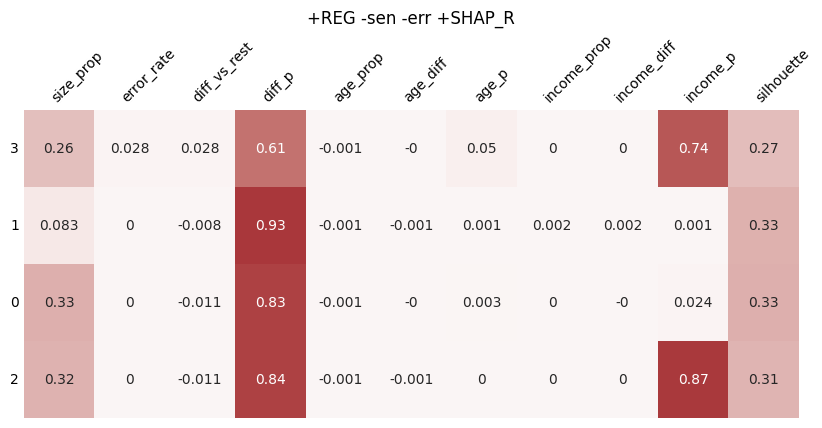

15


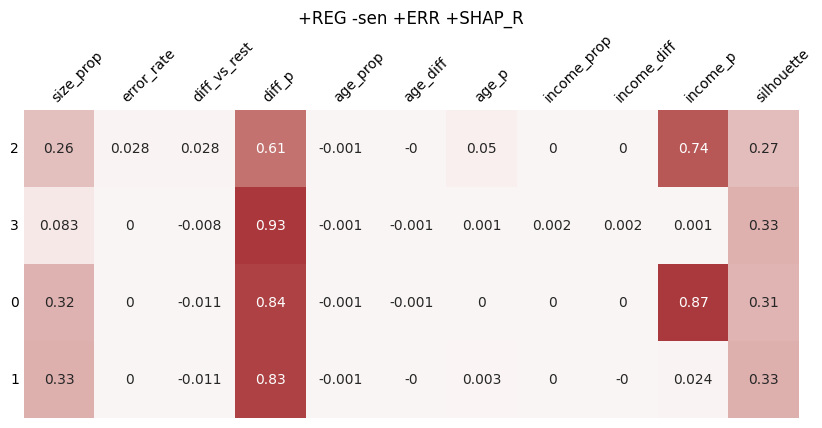

16


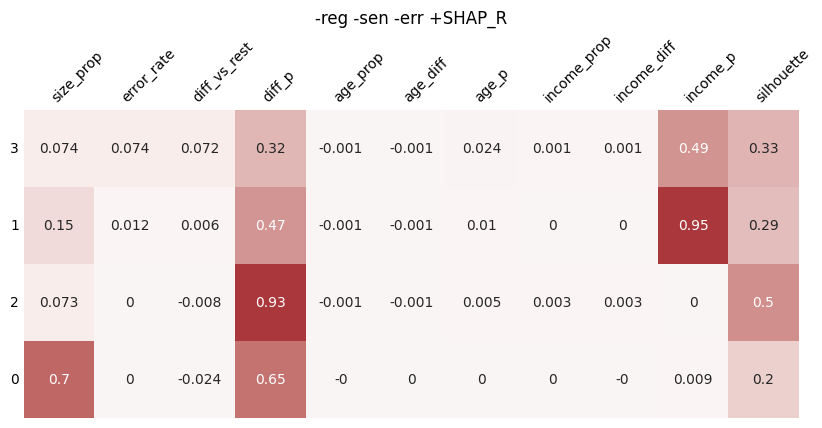

17


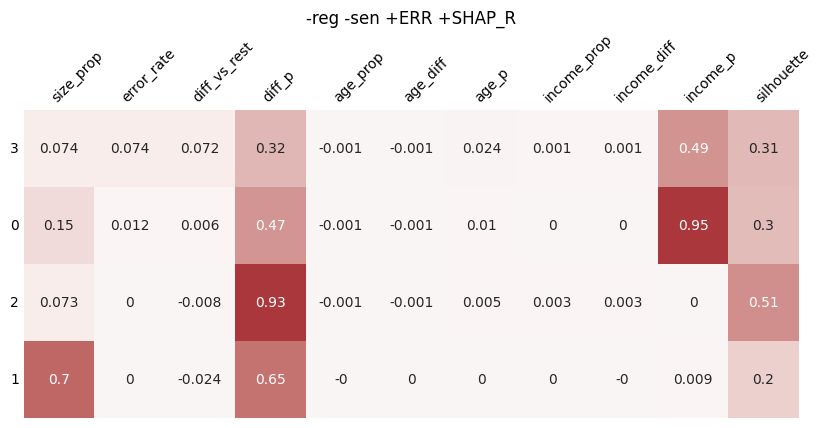

In [ ]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,4))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

t-SNE TNFP data

In [ ]:
for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = REG_scaled + DUMMY_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TNFP_Kmeans_tSNE_')

ValueError: Could not interpret value `Error_Type` for `style`. An entry with this name does not appear in `data`.

<Figure size 1000x700 with 0 Axes>

# TPFN RESULTS

In [ ]:
# Set global seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

results = {'cond_name': [],
           'cond_descr': [],
           'cond_res': [],
           'cond_recap': []}

for i in range(0, len(exp_condition)):
    # Pass seed to ensure reproducibility
    res = hbac_kmeans(TPFN_data.copy(deep=True),
                      columns_to_use=exp_condition['feature_set'][i],
                      error='errors',
                      min_splittable_cluster_prop=min_splittable_cluster_prop,
                      min_acceptable_cluster_prop=min_acceptable_cluster_prop,
                      min_acceptable_error_diff=min_acceptable_error_diff,
                      max_iter=100,
                      random_state=seed_value)  # Assuming hbac_kmeans accepts random_state

    recap = make_recap(res, exp_condition['feature_set'][i])

    results['cond_name'].append(exp_condition['feature_set_name'][i])
    results['cond_descr'].append(exp_condition['feature_set_descr'][i])
    results['cond_res'].append(res)
    results['cond_recap'].append(recap)

c_n_income: -0.11158034356439417
c_count: 567
rest_n_income: 0.6297811875099409
rest_count: 1277
c_n_income: 0.5520445081057926
c_count: 506
rest_n_income: 0.34501494809241556
rest_count: 1338
c_n_income: 0.6846640052324503
c_count: 181
rest_n_income: 0.3710404911016895
rest_count: 1663
c_n_income: 0.4606119236117208
c_count: 181
rest_n_income: 0.39542619571585186
rest_count: 1663
c_n_income: 1.0095395235825078
c_count: 100
rest_n_income: 0.36697853743746117
rest_count: 1744
c_n_income: 0.5182995600908726
c_count: 194
rest_n_income: 0.38812994363124476
rest_count: 1650
c_n_income: 1.0095395235825078
c_count: 115
rest_n_income: 0.36140397711809985
rest_count: 1729
c_n_income: -0.11158034356439417
c_count: 567
rest_n_income: 0.6297811875099409
rest_count: 1277
c_n_income: 0.5520445081057926
c_count: 506
rest_n_income: 0.34501494809241556
rest_count: 1338
c_n_income: 0.6846640052324503
c_count: 181
rest_n_income: 0.3710404911016895
rest_count: 1663
c_n_income: 1.0095395235825078
c_count: 

In [ ]:
# Count the number of missing values in each column
missing_counts = TPFN_data.isnull().sum(axis=0)

# Print the result
print(missing_counts)

income                             0
name_email_similarity              0
customer_age                       0
zip_count_4w                       0
bank_branch_count_8w               0
                                  ..
Shap_device_os_linux_scaled        0
Shap_device_os_macintosh_scaled    0
Shap_device_os_other_scaled        0
Shap_device_os_windows_scaled      0
Shap_device_os_x11_scaled          0
Length: 89, dtype: int64


In [ ]:
anova_res = make_anova_tests(results)
anova_res_viz = anova_res.set_index('cond_name').drop('cond_descr', axis=1)
anova_res_viz = round(anova_res_viz, 6)
anova_res_viz

,error,age,income
cond_name,,,
+REG +SEN -err -shap,0.0,0.0,0.0
+REG +SEN +ERR -shap,0.0,0.0,0.0
+REG +SEN -err +SHAP,0.0,0.0,0.0
+REG +SEN +ERR +SHAP,0.0,0.0,0.0
-reg -sen -err +SHAP,0.0,0.0,0.0
-reg -sen +ERR +SHAP,0.0,0.0,0.0
-reg +SEN -err -shap,0.0,0.0,0.0
-reg +SEN +ERR -shap,0.0,0.0,0.0
-reg +SEN -err +SHAP_S,0.0,0.0,0.0


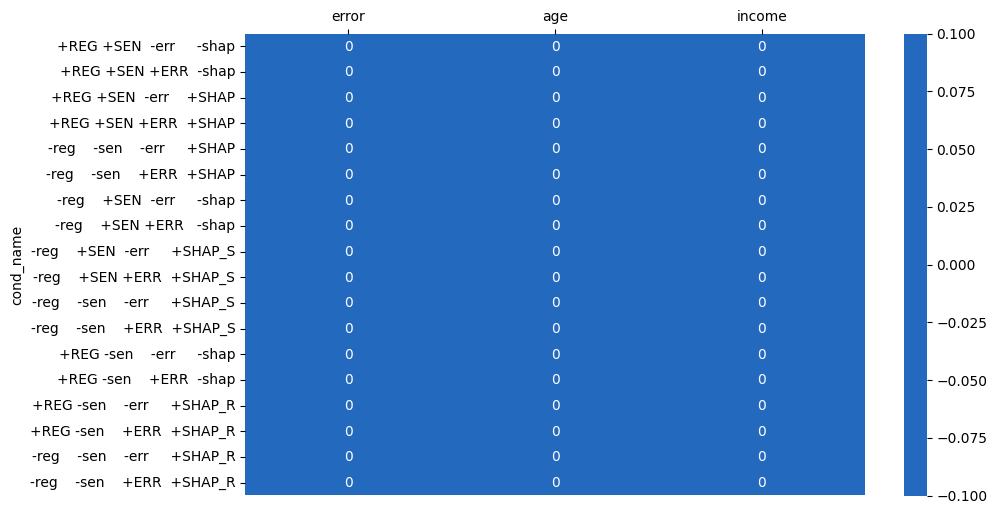

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(#chi_res_viz,
                 anova_res_viz,annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()